# Threads

In [1]:
import os
import sys
import random
import json
from pydantic import BaseModel, Field
from dataclasses import dataclass, field

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, FunctionMessage
from langchain_openai import OpenAI, ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env

In [3]:
set_langsmith_env()
set_chatgpt_env()

In [36]:
# Initialize the LLM
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

def get_last_message(messages):
    """Returns the last message from the state."""
    return messages["messages"][-1].content if messages.get("messages") else None

# Define the state structure
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Define the model calling function
def call_model_node(state: State):
    messages = state["messages"]
    result = llm.invoke(messages)
    return {"messages": [result]}

# Create and configure the graph
workflow = StateGraph(State)
workflow.add_node("agent", call_model_node)
workflow.add_edge(START, "agent")
workflow.add_edge("agent", END)

# Initialize memory for state persistence
checkpointer = MemorySaver()

# Compile the graph
graph = workflow.compile(checkpointer=checkpointer)

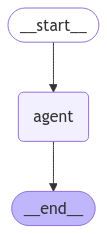

In [37]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## First Thread

In [38]:
config_thread = {
    "configurable": {"thread_id": "t1"}
}

user_input = "Hi there! My name is Will."
result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config_thread)
print(get_last_message(result))

Hello, Will! How can I assist you today?


In [39]:
user_input = "Hi there! did I introduce myself."
result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config_thread)
print(get_last_message(result))

Yes, you did! You mentioned that your name is Will. How can I help you today?


## Second Thread

In [40]:
config_thread = {
    "configurable": {"thread_id": "t2"}
}

user_input = "Hi there! did I introduce myself."
result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config_thread)
print(get_last_message(result))

Hello! You haven't introduced yourself yet. What's your name?
